# Conditional Expectation

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

flagInternetAvailable = True

In [3]:
ndim = 2
gl.defineDefaultSpace(gl.ESpaceType.RN, ndim);

In [4]:
## Load observations
fileNF='Scotland_Temperatures.NF'
if flagInternetAvailable:
    temp_nf, head = urllib.request.urlretrieve('https://soft.minesparis.psl.eu/gstlearn/data/Scotland/'+fileNF,'./'+fileNF)
else:
    temp_nf='./'+fileNF
dat = gl.Db.createFromNF(temp_nf)

## Load grid
fileNF='Scotland_Elevations.NF'
if flagInternetAvailable:
    elev_nf, head = urllib.request.urlretrieve('https://soft.minesparis.psl.eu/gstlearn/data/Scotland/'+fileNF,'./'+fileNF)
else:
    elev_nf='./'+fileNF
grid = gl.DbGrid.createFromNF(elev_nf)

In [5]:
unique_neigh = gl.NeighUnique.create()

Histogram of the raw variable (Temperature)

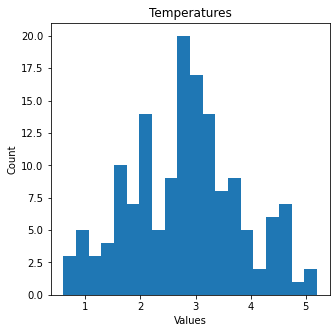

In [6]:
ax = gp.histogram(dat, name="January*", bins=20)
ax.decoration(title="Temperatures")

Gaussian scores

In [7]:
anam = gl.AnamHermite(30)
err = anam.fitFromLocator(dat)
err = anam.rawToGaussian(dat, "January_temp")

In [8]:
anam.display()


Hermitian Anamorphosis
----------------------
Minimum absolute value for Y  = -2.8
Maximum absolute value for Y  = 2.7
Minimum absolute value for Z  = 0.62599
Maximum absolute value for Z  = 5.24756
Minimum practical value for Y = -2.8
Maximum practical value for Y = 2.7
Minimum practical value for Z = 0.62599
Maximum practical value for Z = 5.24756
Mean                          = 2.81457
Variance                      = 1.01677
Number of Hermite polynomials = 30
Normalized coefficients for Hermite polynomials (punctual variable)
               [,  0]    [,  1]    [,  2]    [,  3]    [,  4]    [,  5]    [,  6]
     [  0,]     2.815    -1.003     0.010     0.067     0.005     0.030    -0.007
     [  7,]    -0.035     0.009     0.027    -0.011    -0.019     0.014     0.013
     [ 14,]    -0.017    -0.008     0.019     0.004    -0.020    -0.001     0.020
     [ 21,]    -0.002    -0.018     0.004     0.016    -0.005    -0.014     0.006
     [ 28,]     0.011    -0.005
 

Plot the Gaussian scores

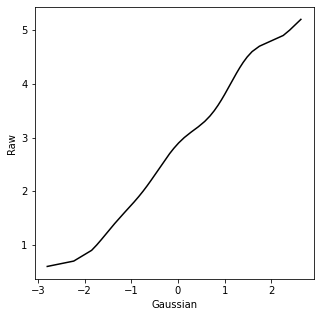

In [9]:
ax = gp.sortedcurve(tabx=dat["Y.January_temp"], taby=dat["January_temp"])
ax.decoration(xlabel="Gaussian",ylabel="Raw")

Draw the histogram of the Gaussian transformed values

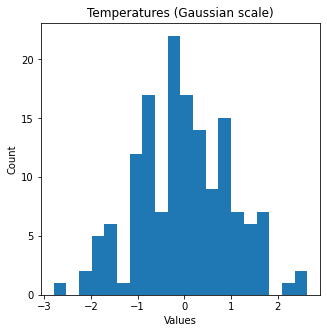

In [10]:
ax = gp.histogram(dat, name="Y.January*", bins=20)
ax.decoration(title="Temperatures (Gaussian scale)")

We calculate the experimental directional variogram of the gaussian scores and fit the Model (with the constraints that sill should be 1)

In [11]:
varioparam = gl.VarioParam.createMultiple(ndir=2, npas=40, dpas=10)
vario_gauss2dir = gl.Vario.create(varioparam, dat)
err = vario_gauss2dir.compute()

fitmodgauss = gl.Model()
err = fitmodgauss.fit(vario_gauss2dir, 
                types=[gl.ECov.NUGGET, gl.ECov.SPHERICAL, gl.ECov.CUBIC],
                constraints = gl.Constraints(1))

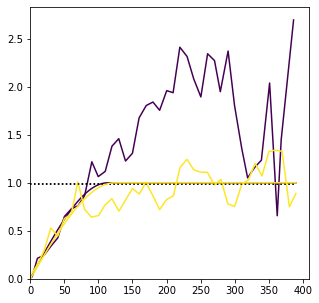

In [12]:
ax = gp.varmod(vario_gauss2dir, fitmodgauss)

In [13]:
neighU = gl.NeighUnique.create()

Kriging of Gaussian scores

In [14]:
err = gl.kriging(dat, grid, fitmodgauss, neighU)

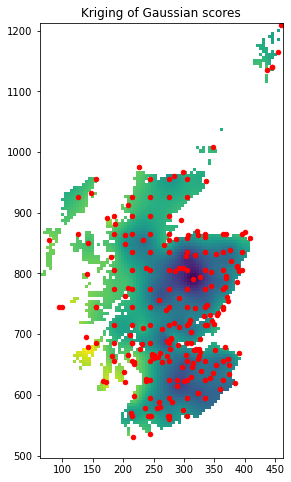

In [15]:
gp.setDefaultGeographic(dims=[8,8])
ax = grid.plot("*estim")
ax = dat.plot()
ax.decoration(title="Kriging of Gaussian scores")

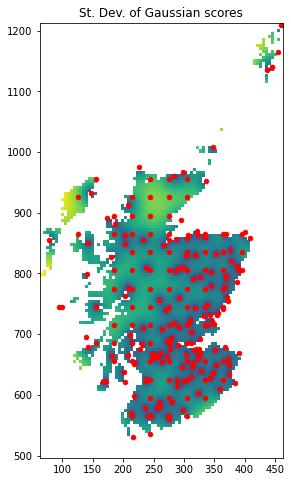

In [16]:
ax = grid.plot("*stdev")
ax = dat.plot(flagCst=True)
ax.decoration(title="St. Dev. of Gaussian scores")

## Conditional Expectation

We use the Monte Carlo method with 1000 outcomes.

In [17]:
selectivity = gl.Selectivity.createByKeys(["Z"], [], flag_est=True, flag_std=True)
err = gl.ConditionalExpectation(grid, anam, selectivity, "K*.estim", "K*.stdev", nbsimu=100,
                                namconv=gl.NamingConvention("CE",False,True,False))

Display of the Conditional Expectation

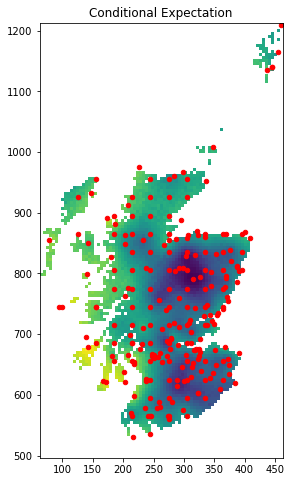

In [18]:
ax = grid.plot("CE*estim")
ax = dat.plot()
ax.decoration(title = "Conditional Expectation")

Display of the Conditional Standard Deviation

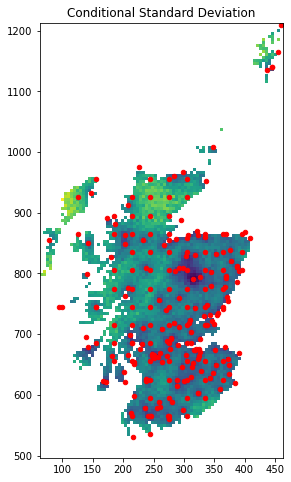

In [19]:
ax = grid.plot("CE*stdev")
ax = dat.plot(flagCst=True)
ax.decoration(title="Conditional Standard Deviation")

Conditional Probability below 0

In [20]:
selectivity = gl.Selectivity.createByKeys(["PROP"], zcuts=[0],flag_est=True, flag_std=True)
err = gl.ConditionalExpectation(grid, anam, selectivity, "K*.estim", "K*.stdev",
                                namconv=gl.NamingConvention("CE",False,True,False))

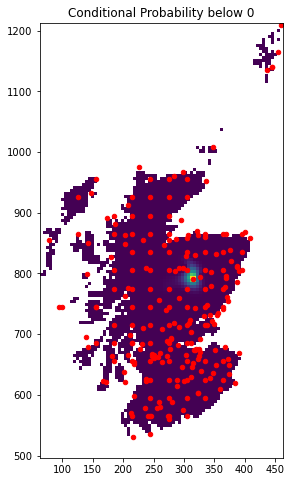

In [21]:
ax = grid.plot("CE.Proba*estim")
ax = dat.plot()
ax.decoration(title = "Conditional Probability below 0")

Conditional Probability above 1

In [22]:
selectivity = gl.Selectivity.createByKeys(["T"], zcuts=[1],flag_est=True, flag_std=True)
err = gl.ConditionalExpectation(grid, anam, selectivity, "K*.estim", "K*.stdev",
                                namconv=gl.NamingConvention("CE",False,True,False))

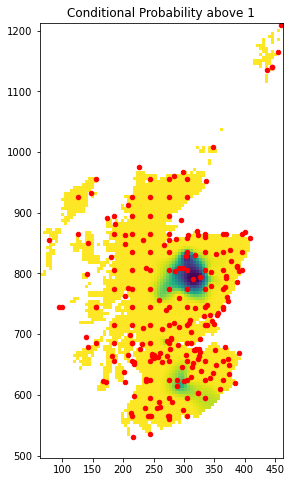

In [23]:
ax = grid.plot("CE.T*estim-1")
ax = dat.plot()
ax.decoration(title = "Conditional Probability above 1")

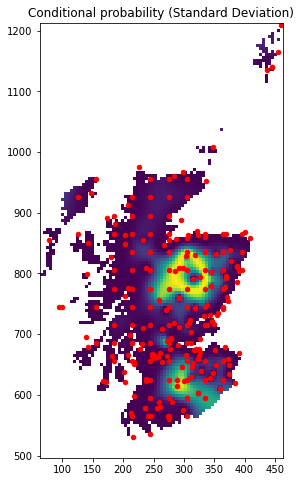

In [24]:
ax = grid.plot("CE.T*stdev-1")
ax = dat.plot(flagCst=True)
ax.decoration(title = "Conditional probability (Standard Deviation)")